# Do a Marker-based Segmentation of LWP

We will apply the segmentation to the one mode (e.g. `mode = 'scattering'`) and then use these labels for the segmenation of the other mode.

## Import Libraries

In [168]:
%matplotlib inline

import sys, os
import datetime
import numpy as np
import xarray as xr
xr.set_options( keep_attrs = True )

import importlib
import scipy.ndimage

import pylab as plt
plt.rcParams['figure.figsize'] = (12,8)
import seaborn as sns
sns.set_context( 'talk' )

from cycler import cycler


import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H')

# import nawdex_analysis.io.tools

In [169]:
tools_dir = '%s/proj/2017-11_icon-de-lem-analysis/tools' % os.environ['HOME']

import sys
sys.path.append(tools_dir)

In [170]:
import advanced_segmentation
importlib.reload( advanced_segmentation )

<module 'advanced_segmentation' from '/pf/b/b380352/proj/2017-11_icon-de-lem-analysis/tools/advanced_segmentation.py'>

## Open LWP Data 

The data have been combined with the script:
    
```
/mnt/lustre01/pf/b/b380352/proj/2017-11_icon-de-lem-analysis/inout/combine_lwp_field.py
```

In [171]:
lwp = xr.open_dataset( '%s/icon-lem/aggregates/lwp_combined.nc' % os.environ['LOCAL_DATA_PATH'] )

In [172]:
lwp.load()

lwp = lwp * 1e3
lwp['clwvi'].attrs['units'] = 'g m-3'
lwp['clwvi'].attrs['long_name'] = 'liquid-water path'
lwp['clwvi'].attrs['standard_name'] = '$Q_c$'

lwp['clwvi'].attrs

{'standard_name': '$Q_c$',
 'long_name': 'liquid-water path',
 'units': 'g m-3',
 'param': '215.1.0',
 'institution': 'MPIMET'}

In [173]:
lwp

<xarray.Dataset>
Dimensions:  (dom: 2, lat: 155, lon: 139, mode: 2, time: 19)
Coordinates:
  * dom      (dom) object 'DOM01' 'DOM02'
  * mode     (mode) object 'absorbing' 'scattering'
  * time     (time) datetime64[ns] 2013-05-02T06:00:00 ... 2013-05-03
  * lat      (lat) float64 47.5 47.54 47.59 47.63 ... 54.28 54.32 54.37 54.41
  * lon      (lon) float64 4.5 4.572 4.643 4.715 ... 14.15 14.22 14.3 14.37
Data variables:
    clwvi    (mode, dom, time, lat, lon) float32 12.887113 ... 5.787036e-09

## Select Time Range

In [174]:
t_start = '2013-05-02T08'
t_end = '2013-05-02T14'

lwp = lwp.sel(time = slice(t_start, t_end))

## Run the Toolbox

In [175]:
thresh = 200.
labels_a2s = advanced_segmentation.run_seg_with_marker_xarray(lwp, thresh,  
                                                              template_mode = 'absorbing', 
                                                              mirror_mode = 'scattering' )

labels_s2a = advanced_segmentation.run_seg_with_marker_xarray(lwp, thresh,  
                                                              template_mode = 'scattering', 
                                                              mirror_mode = 'absorbing' )


...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field
...take predefined marker field


/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/tropy/analysis_tools/segmentation.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if marker_field == 'dist':
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/tropy/analysis_tools/segmentation.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if marker_field == 'dist':


### Combine both Labeling Results

In [176]:
lab_a2s = labels_a2s.expand_dims( 'lmap' )
lab_a2s['lmap'] = ['a2s', ]

lab_s2a = labels_s2a.expand_dims( 'lmap' )
lab_s2a['lmap'] = ['s2a', ]

labels = xr.concat( [lab_a2s, lab_s2a], dim = 'lmap' )

    

## Example Plots

In [177]:
lon = lwp.lon.data
lat = lwp.lat.data

f1 = lwp['clwvi'].isel(time = 5, dom = 1, mode = 0).data
f2 = lwp['clwvi'].isel(time = 5, dom = 1, mode = 1).data

c1 = labels_a2s['cluster'].isel(time = 5, dom = 1, mode = 0).data
c2 = labels_a2s['cluster'].isel(time = 5, dom = 1, mode = 1).data


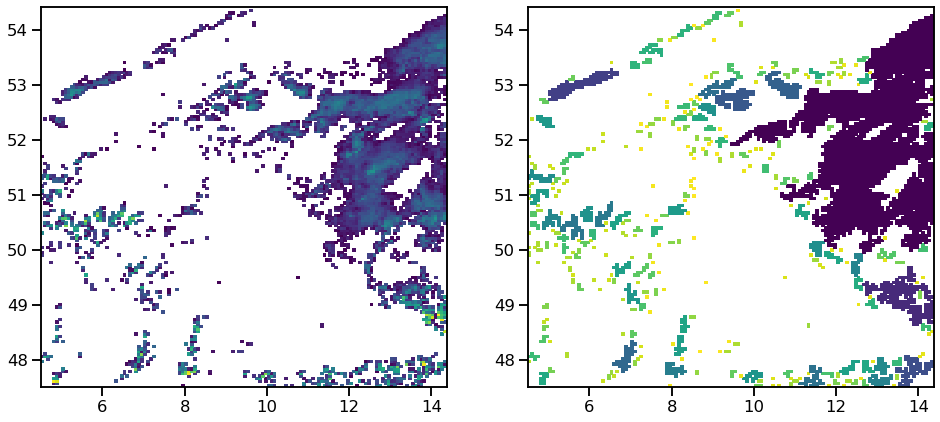

In [178]:
fig, a = plt.subplots(ncols = 2, figsize = (16,7))
a[0].pcolormesh( lon, lat, np.ma.log( np.ma.masked_less(f1, thresh)) )
a[1].pcolormesh( lon, lat, np.ma.log( c1.T ) )


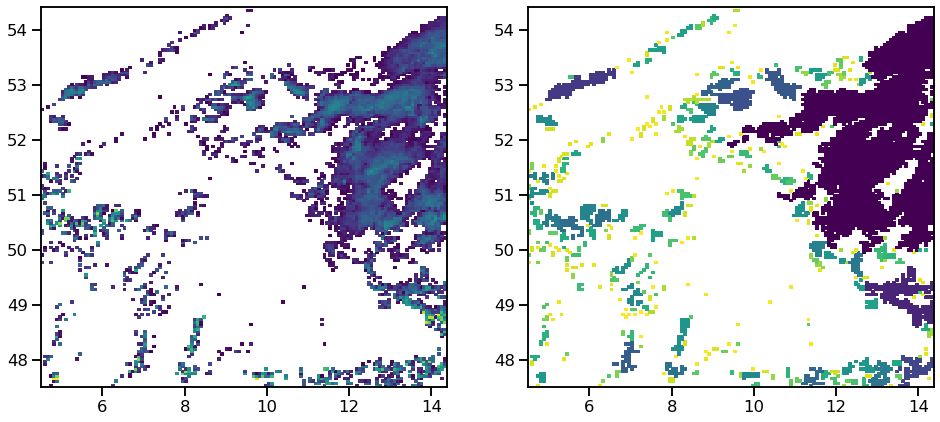

In [179]:
fig, a = plt.subplots(ncols = 2, figsize = (16,7))
a[0].pcolormesh( lon, lat, np.ma.log( np.ma.masked_less(f2, thresh)) )
a[1].pcolormesh( lon, lat, np.ma.log( c2.T ) )


In [180]:
diff = np.where( c2 - c1 == 0, 1, 4)

diff = np.where( (c1 == 0) & (c2 != 0), 2, diff )
diff = np.where( (c2 == 0) & (c1 != 0), 3, diff )
diff = np.ma.masked_where( (c2 == 0) & (c1 == 0), diff )


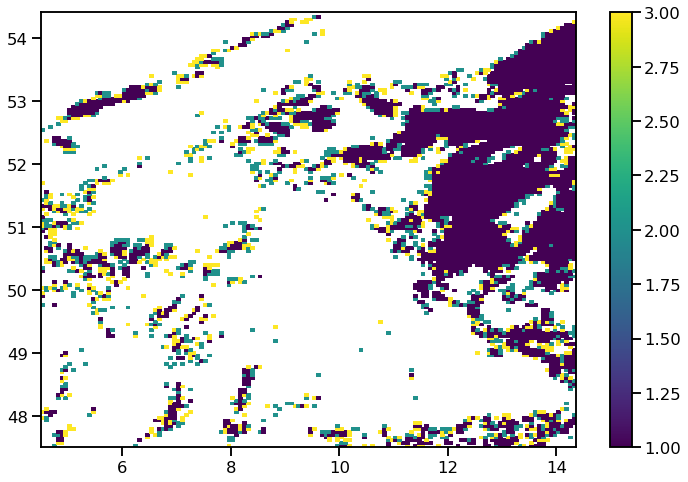

In [181]:
plt.pcolormesh( lon, lat, diff.T )
plt.colorbar()

## Simple Helper Function to Derive Size and Label

In [182]:
def label_and_size( c, nmax = 3000 ):
    
    # get maximum label
    # =================
    max_label = c.max()
    
    
    # set pixel area template (here in units of px)
    # =======================
    o = np.ones_like( c )
    
    
    # count number of pixels per object label
    # =======================================
    labels = np.arange(1, max_label + 1)
    sizes = scipy.ndimage.measurements.sum( o, labels = c, index = labels )
    
    
    # map on extended vectors (to have all of equal length)
    # =====================================================
    ext_labels = np.arange(1, nmax + 1)
    ext_sizes = np.zeros( nmax  )
    
    if max_label <= nmax:
        ext_labels[:max_label] = labels
        ext_sizes[:max_label]  = sizes
    else:
        raise Exception('Error: increase `nmax` argument.')
    
    
    # create DataArray
    # ================
    coords = {'label': ext_labels}
    dims = ['label']
    
    d = xr.DataArray(data = ext_sizes, coords = coords, dims = dims, name = 'sizes')
    return d

In [183]:
label_and_size( c1 )

<xarray.DataArray 'sizes' (label: 3000)>
array([2685.,  213.,   95., ...,    0.,    0.,    0.])
Coordinates:
  * label    (label) int64 1 2 3 4 5 6 7 ... 2994 2995 2996 2997 2998 2999 3000

In [184]:
sizes = xr.apply_ufunc( label_and_size, labels,
                input_core_dims = [ ['lon', 'lat'], ], 
                output_core_dims=[['label']],
                vectorize = True,)
   

In [185]:
sizes.isel( time = 5, dom = 0)

<xarray.Dataset>
Dimensions:  (label: 3000, lmap: 2, mode: 2)
Coordinates:
    thresh   float64 200.0
    dom      <U5 'DOM01'
  * mode     (mode) object 'absorbing' 'scattering'
    time     datetime64[ns] 2013-05-02T13:00:00
  * lmap     (lmap) object 'a2s' 's2a'
Dimensions without coordinates: label
Data variables:
    cluster  (lmap, mode, label) float64 2.688e+03 192.0 115.0 ... 0.0 0.0 0.0

## Budget Considerations

### How much area is covered by all cells?

In [186]:
mask_append = sizes['cluster'].sum('mode') != 0

In [187]:
s = sizes.where( mask_append )['cluster']

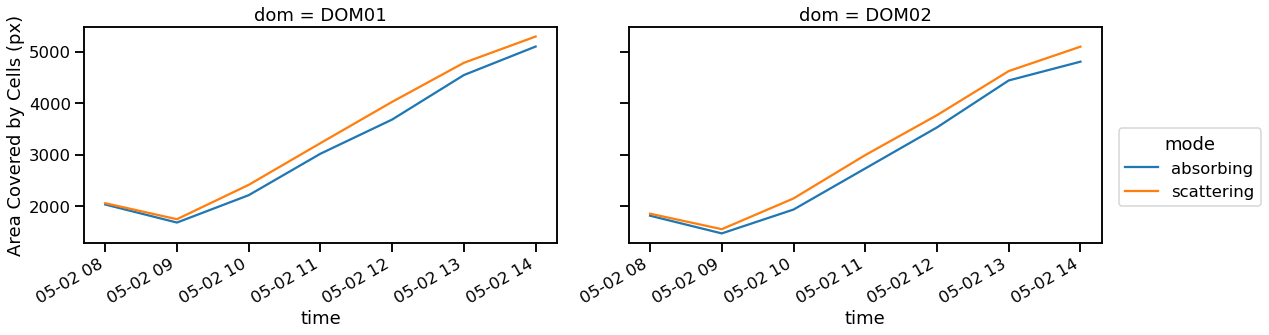

In [188]:
pkws = dict( hue = 'mode', col = 'dom', figsize = (16,5) )
s.sum('label').mean('lmap').plot(**pkws)

fig = plt.gcf()
fig.axes[0].set_ylabel('Area Covered by Cells (px)');

### Normalize Contribution by Total Pixel Number

In [189]:
npix_all = lwp.dims['lon'] * lwp.dims['lat']

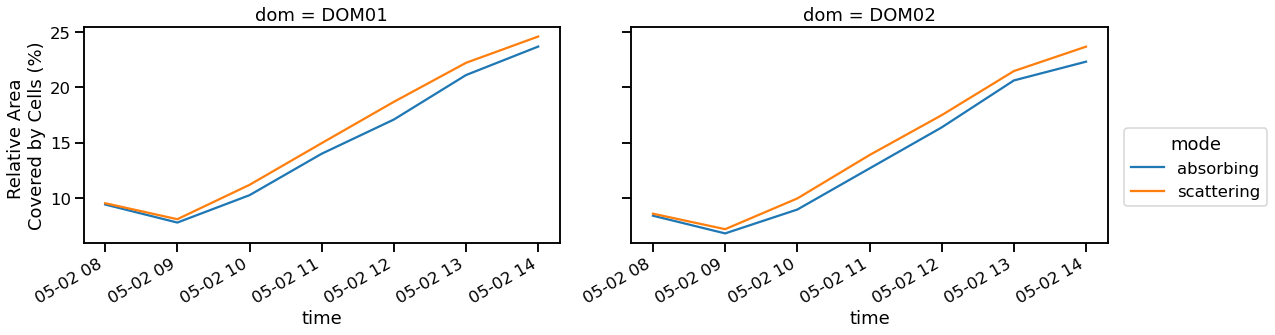

In [190]:
(100. / npix_all * s.sum('label').mean('lmap')).plot(**pkws)

fig = plt.gcf()
fig.axes[0].set_ylabel('Relative Area \nCovered by Cells (%)');

### How many cells appear only in one of the simulations?

In [191]:
s_sca = s.sel( mode = 'scattering' )
s_abs = s.sel( mode = 'absorbing' )

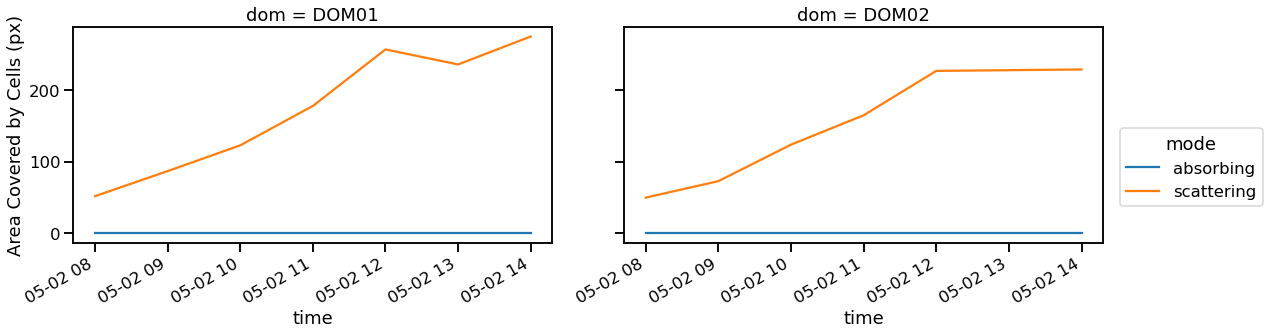

In [192]:
mask_only_in_scatt = (s_sca != 0) & (s_abs == 0)
s.where( mask_only_in_scatt ).sum('label').mean('lmap').plot(**pkws)

fig = plt.gcf()
fig.axes[0].set_ylabel('Area Covered by Cells (px)');

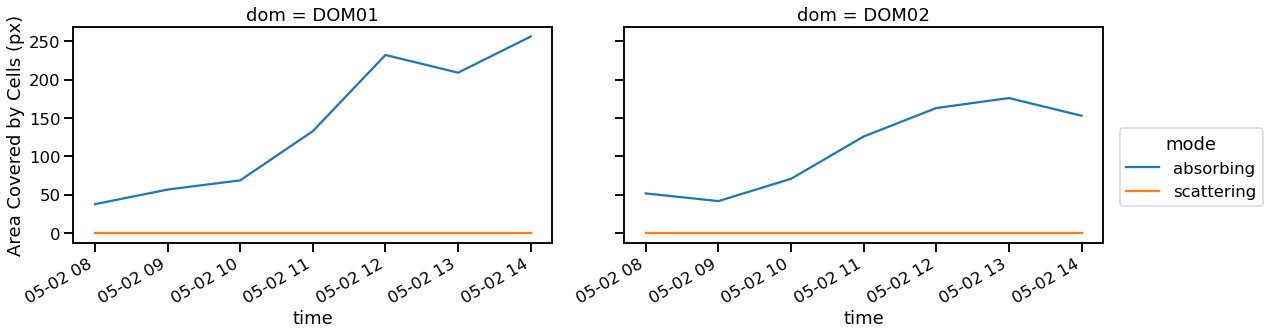

In [193]:
mask_only_in_abs = (s_abs != 0) & (s_sca == 0)
s.where( mask_only_in_abs ).sum('label').mean('lmap').plot(**pkws)


fig = plt.gcf()
fig.axes[0].set_ylabel('Area Covered by Cells (px)');

### Either new in one or the other

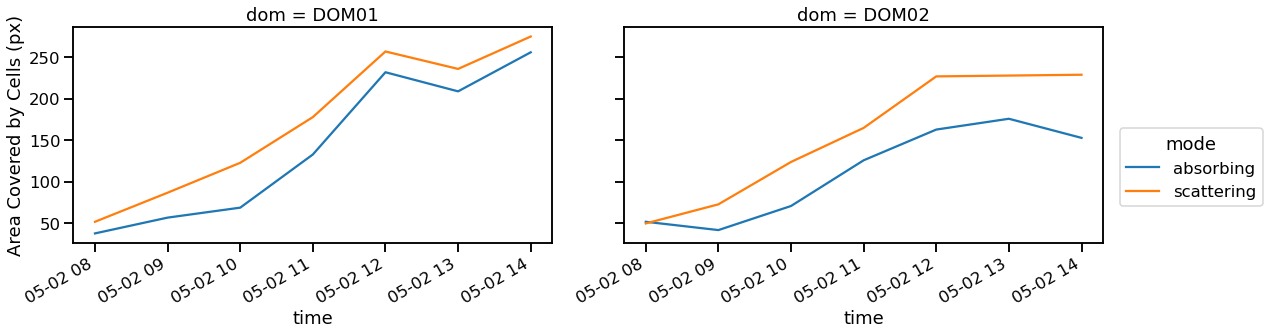

In [194]:
mask_new = ( (s_sca != 0) & (s_abs == 0) ) | ( (s_abs != 0) & (s_sca == 0) )
s.where( mask_new ).sum('label').mean('lmap').plot(**pkws)


fig = plt.gcf()
fig.axes[0].set_ylabel('Area Covered by Cells (px)');

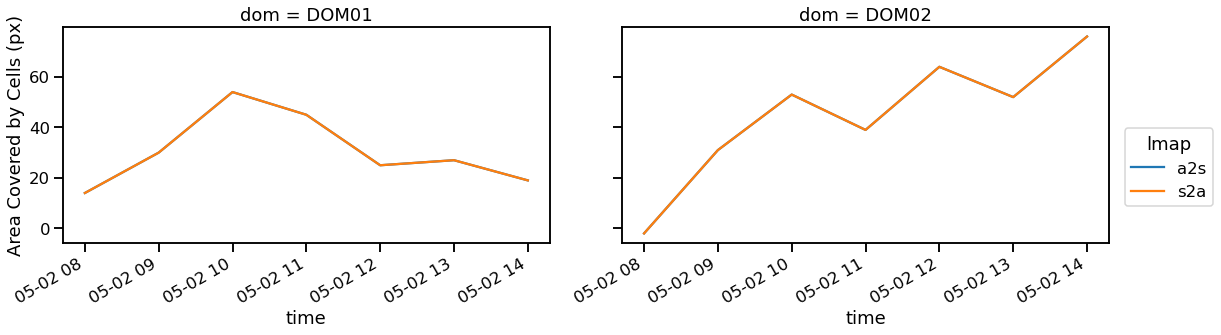

In [195]:
mask_new = ( (s_sca != 0) & (s_abs == 0) ) | ( (s_abs != 0) & (s_sca == 0) )
s.where( mask_new ).diff('mode').sum('label').plot(col = 'dom', hue = 'lmap',figsize = (16,5) )


fig = plt.gcf()
fig.axes[0].set_ylabel('Area Covered by Cells (px)');

### How many cells appear in both simulations?

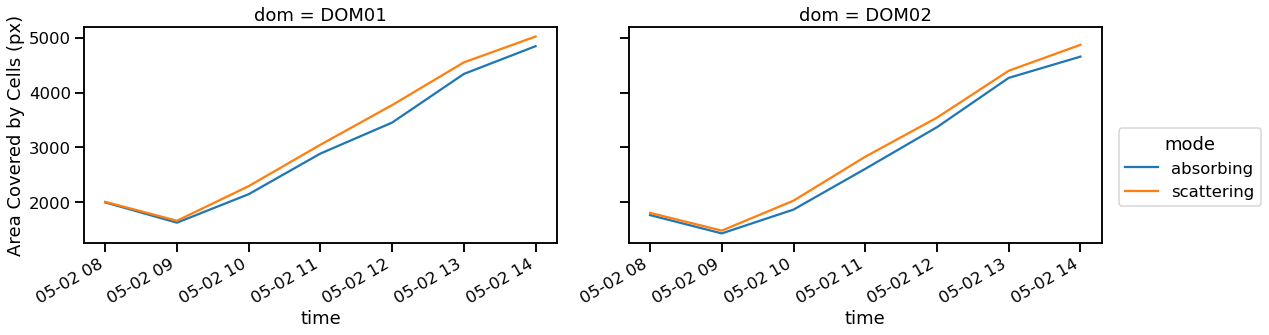

In [196]:
mask_in_both = (s_sca != 0) & (s_abs != 0)
s.where( mask_in_both ).sum('label').mean('lmap').plot(**pkws)


fig = plt.gcf()
fig.axes[0].set_ylabel('Area Covered by Cells (px)');

### Which cell size is mainly contributing to the difference?

In [197]:
sboth = s.where( mask_in_both )

In [198]:
smean = sboth.mean('mode')
sdiff = sboth.sel(mode = 'absorbing') - sboth.sel(mode = 'scattering')


/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


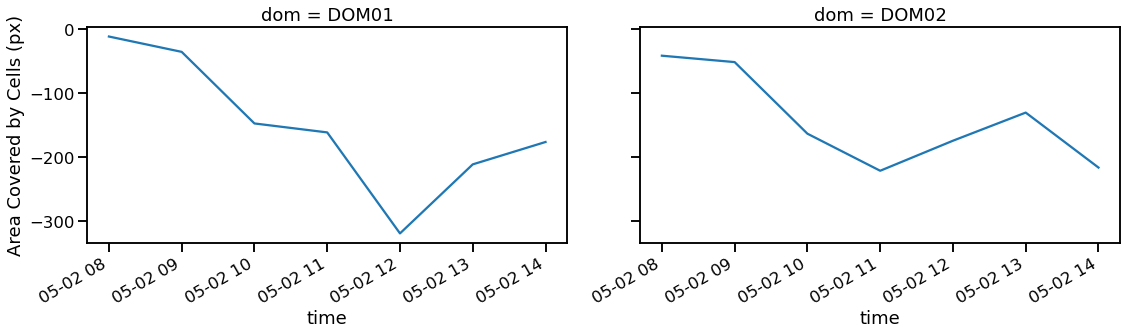

In [199]:
sdiff.sum('label').mean('lmap').plot(**pkws)


fig = plt.gcf()
fig.axes[0].set_ylabel('Area Covered by Cells (px)');

In [200]:

######################################################################
######################################################################

def binwise_average(variable, 
                    selector, 
                    selector_bins, 
                    operator = np.ma.mean):
    
    '''
    Calculates Average of one variable conditioned on the range of a second 
    variable.
    
    Parameters
    ----------
    variable : np.array
        variable name for which average is calculated
    
    selector : np.array
        variable name which is selected for conditioning
    
    selector_bins : list or tuple
        bin values for conditioning
    
    operator : func, optional, default = np.ma.mean
        function applied for statistics (e.g. averaging)
    
    Returns
    -------
    stats : numpy array, 
        binwise-statistics
        
    '''

    # extract variable and selector
    v = variable
    s = selector

    mfinite = np.isfinite( v )
    
    # get number of bins
    nbins = len( selector_bins )

    
    # get time array
    stats  = np.zeros((nbins - 1))

      
    for i in range(nbins - 1):
                
        # set bin edges 
        s1 = selector_bins[i]
        s2 = selector_bins[i + 1]
    
        # prepare mask
        m = (s >= s1) & (s < s2) & mfinite
            
        # do the averaging
        if sum(m) == 0:
            stats[i] = np.nan
        else:
            stats[i] = operator( v[m] )
            
    stats = np.ma.masked_invalid( stats )
    
    return stats


In [201]:
selector = smean.isel( dom = 0, lmap = 0, time = 3).squeeze()
variable = sdiff.isel( dom = 0, lmap = 0, time = 3).squeeze()


In [202]:
sbins = 2**np.arange(15)

In [203]:
sbins

array([    1,     2,     4,     8,    16,    32,    64,   128,   256,
         512,  1024,  2048,  4096,  8192, 16384])

In [204]:
binwise_average( variable, selector, sbins)

masked_array(data=[-0.08064516129032258, -0.5303030303030303,
                   -0.6923076923076923, -1.0555555555555556,
                   -0.36363636363636365, -0.6666666666666666, 6.0, -6.0,
                   -32.0, --, -35.0, --, --, --],
             mask=[False, False, False, False, False, False, False, False,
                   False,  True, False,  True,  True,  True],
       fill_value=1e+20)

In [205]:
smean

<xarray.DataArray 'cluster' (lmap: 2, dom: 2, time: 7, label: 3000)>
array([[[[ 652. ,  325.5,  305.5, ...,    nan,    nan,    nan],
         [ 358. ,  315. ,  270. , ...,    nan,    nan,    nan],
         [ 574.5,  292. ,  239. , ...,    nan,    nan,    nan],
         ...,
         [2000. ,  230. ,  109.5, ...,    nan,    nan,    nan],
         [2719.5,  195.5,  115.5, ...,    nan,    nan,    nan],
         [3207.5,  154.5,  131.5, ...,    nan,    nan,    nan]],

        [[ 879.5,  317. ,  104.5, ...,    nan,    nan,    nan],
         [ 301. ,  298.5,  265.5, ...,    nan,    nan,    nan],
         [ 501. ,  282.5,  223. , ...,    nan,    nan,    nan],
         ...,
         [1952.5,  185. ,  120. , ...,    nan,    nan,    nan],
         [2723. ,  211.5,   96. , ...,    nan,    nan,    nan],
         [3040. ,  274.5,   84.5, ...,    nan,    nan,    nan]]],


       [[[ 961.5,  324. ,  259.5, ...,    nan,    nan,    nan],
         [ 359.5,  315. ,  277. , ...,    nan,    nan,    nan],
         [ 600.5,  291. ,  266. , ...,    nan,    nan,    nan],
         ...,
         [1916.5,  244. ,  196.5, ...,    nan,    nan,    nan],
         [2738. ,  200.5,  187.5, ...,    nan,    nan,    nan],
         [3203.5,  124. ,  114.5, ...,    nan,    nan,    nan]],

        [[ 614.5,  314.5,  288. , ...,    nan,    nan,    nan],
         [ 324. ,  300.5,  265.5, ...,    nan,    nan,    nan],
         [ 532. ,  237. ,  234.5, ...,    nan,    nan,    nan],
         ...,
         [2026.5,  182. ,  119. , ...,    nan,    nan,    nan],
         [2690.5,  213. ,  102. , ...,    nan,    nan,    nan],
         [3118.5,  328. ,  146. , ...,    nan,    nan,    nan]]]])
Coordinates:
    thresh   float64 200.0
  * dom      (dom) object 'DOM01' 'DOM02'
  * time     (time) datetime64[ns] 2013-05-02T08:00:00 ... 2013-05-02T14:00:00
  * lmap     (lmap) object 'a2s' 's2a'
Dimensions without coordinates: label

In [206]:
sizediffs = xr.apply_ufunc( binwise_average, sdiff, smean, sbins,
                input_core_dims = [ ['label'],['label'],['sbin'], ], 
                output_core_dims=[['bin']],
                vectorize = True, kwargs = dict( operator = np.sum) )
   

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater_equal
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


In [207]:
dx = 5.
area = dx**2 * sbins
diameters_edges =  2 * np.sqrt(area / np.pi)
diameters_centers =  0.5* (diameters_edges[1:] + diameters_edges[:-1] )


diameters = xr.DataArray( data = diameters_centers, dims = 'bin')
diameters.attrs['units'] = 'km'
sizediffs = sizediffs.assign_coords({'diameter':diameters})

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


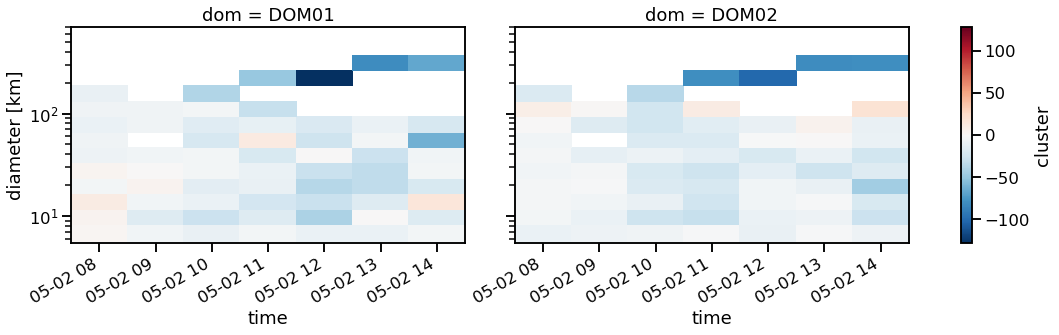

In [208]:
sizediffs.mean('lmap').plot( col = 'dom', x = 'time', y = 'diameter', figsize = (16,5) )
plt.yscale( 'log' )

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


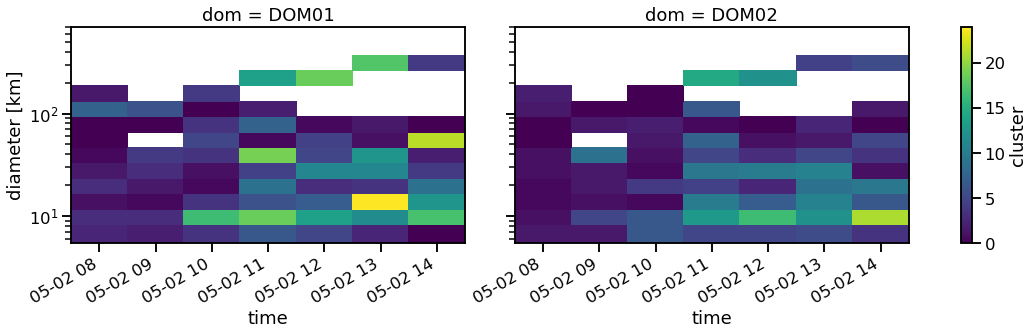

In [209]:
sizediffs.std('lmap').plot( col = 'dom', x = 'time', y = 'diameter', figsize = (16,5) )
plt.yscale( 'log' )

### Relative Contributions

In [210]:
sizediffs_rel = 100. / npix_all * sizediffs.fillna( 0. )

sizediffs_rel.attrs = {'units': '%', 'long_name': 'relative contribution'}


In [211]:
sizediffs_rel

<xarray.DataArray 'cluster' (lmap: 2, dom: 2, time: 7, bin: 14)>
array([[[[ 0.        ,  0.0092829 ,  0.04641448, -0.00464145,
           0.02320724, -0.02784869, -0.02784869, -0.04177303,
           0.0092829 , -0.03713159,  0.        ,  0.        ,
           0.        ,  0.        ],
         [-0.03249014, -0.09282896, -0.02320724,  0.02784869,
          -0.0092829 , -0.00464145,  0.        , -0.02784869,
           0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ],
         [-0.06033883, -0.20422372, -0.02320724, -0.06498027,
          -0.01392434,  0.        , -0.07890462, -0.05569738,
          -0.01856579, -0.16245068,  0.        ,  0.        ,
           0.        ,  0.        ],
         [-0.04641448, -0.16245068, -0.08354607, -0.08818751,
          -0.01856579, -0.0092829 ,  0.05569738, -0.08354607,
          -0.14852634,  0.        , -0.16245068,  0.        ,
           0.        ,  0.        ],
         [-0.06498027, -0.2506382 , -0.16709213, -0.18565793,
          -0.08354607, -0.02320724, -0.10211186, -0.09282896,
           0.        ,  0.        , -0.51055929,  0.        ,
           0.        ,  0.        ],
         [-0.05105593, -0.05105593, -0.19029937, -0.16709213,
          -0.10211186, -0.06962172, -0.02320724, -0.03249014,
           0.        ,  0.        ,  0.        , -0.29241123,
           0.        ,  0.        ],
         [-0.01856579, -0.16245068,  0.01392434, -0.05569738,
           0.        , -0.01392434, -0.18565793, -0.10211186,
           0.        ,  0.        ,  0.        , -0.29241123,
           0.        ,  0.        ]],

        [[-0.04641448, -0.02320724, -0.01392434, -0.01392434,
          -0.01856579, -0.01856579, -0.02320724,  0.        ,
           0.04641448, -0.07890462,  0.        ,  0.        ,
           0.        ,  0.        ],
         [-0.03713159, -0.06498027, -0.02784869, -0.01392434,
          -0.01856579, -0.01392434,  0.        , -0.06962172,
           0.0092829 ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ],
         [-0.05569738, -0.15316779, -0.04641448, -0.06962172,
          -0.09747041, -0.03249014, -0.07890462, -0.10675331,
          -0.1160362 ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ],
         [-0.03249014, -0.19958227, -0.16709213, -0.07890462,
          -0.16709213, -0.03713159, -0.05105593, -0.06962172,
           0.07890462,  0.        , -0.30169413,  0.        ,
           0.        ,  0.        ],
         [-0.06962172, -0.1160362 , -0.05569738, -0.0092829 ,
          -0.01392434, -0.08354607,  0.        , -0.04641448,
           0.        ,  0.        , -0.41308888,  0.        ,
           0.        ,  0.        ],
         [-0.03249014, -0.08818751, -0.05569738, -0.00464145,
          -0.07426317, -0.01856579,  0.0092829 ,  0.01392434,
           0.        ,  0.        ,  0.        , -0.35275006,
           0.        ,  0.        ],
         [-0.04641448, -0.22743096, -0.06498027, -0.16245068,
          -0.07426317, -0.09747041, -0.06498027,  0.        ,
           0.07890462,  0.        ,  0.        , -0.34346716,
           0.        ,  0.        ]]],


       [[[ 0.02320724,  0.03713159,  0.05569738, -0.03249014,
           0.0092829 , -0.03249014,  0.        ,  0.        ,
          -0.06033883, -0.05105593,  0.        ,  0.        ,
           0.        ,  0.        ],
         [-0.01392434, -0.06498027, -0.01856579,  0.01392434,
           0.01856579, -0.04177303,  0.        ,  0.        ,
          -0.05569738,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ],
         [-0.02784869, -0.05105593, -0.05569738, -0.06033883,
          -0.02320724, -0.03249014, -0.1253191 , -0.08818751,
          -0.01856579, -0.19958227,  0.        ,  0.        ,
           0.        ,  0.        ],
         [ 0.01392434,  0.0092829 , -0.13924344, -0.00464145,
          -0.06033883, -0.18565793,  0.05105593, -0.01392434,
          -0.1

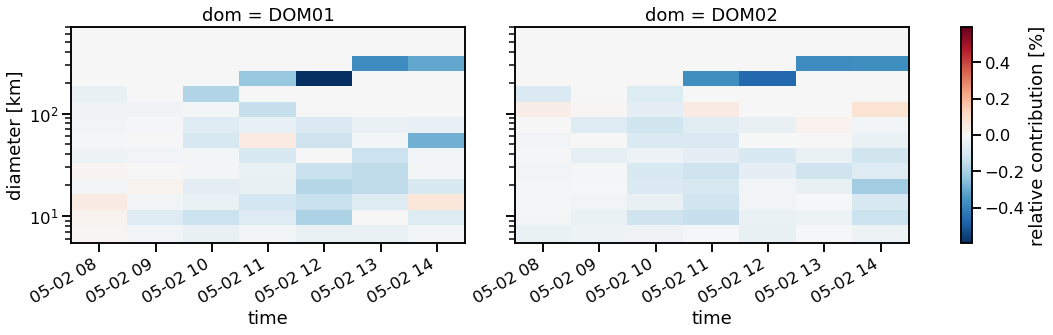

In [212]:
sizediffs_rel.mean('lmap').plot( col = 'dom', x = 'time', y = 'diameter', figsize = (16,5) )
plt.yscale( 'log' )

Text(0.5, 1.0, 'Size-Resolved Changes of Fractional Aera Coverage for LWP > 200 g / m^2')

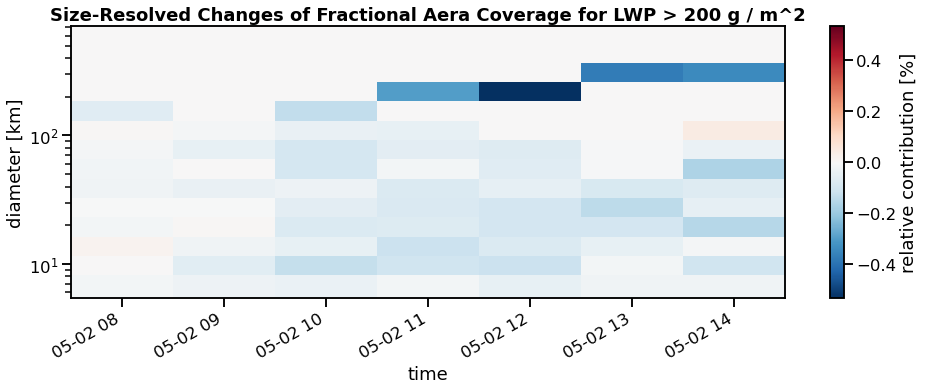

In [213]:
sd_both = sizediffs_rel.mean(['lmap','dom']).squeeze()

sd_both.plot( x = 'time', y = 'diameter', figsize = (16,5) )
plt.yscale( 'log' )
plt.title('Size-Resolved Changes of Fractional Aera Coverage for LWP > %d g / m^2' % thresh,
         fontweight = 'bold')

In [214]:
sd_both.mean(['time', ]).sum('bin') 

<xarray.DataArray 'cluster' ()>
array(-0.68162981)
Coordinates:
    thresh   float64 200.0
Attributes:
    units:      %
    long_name:  relative contribution

## How much do new cells contribute and which sizes?

In [215]:
mask_sca = ( (s_sca != 0) & (s_abs == 0) )
snew_sca = s.where( mask_sca ).sel(mode = 'scattering')

In [216]:
mask_abs = ( (s_sca == 0) & (s_abs != 0) )
snew_abs = s.where( mask_abs ).sel(mode = 'absorbing')

In [217]:
size_distrib_newsca = xr.apply_ufunc( binwise_average, snew_sca, snew_sca, sbins,
                input_core_dims = [ ['label'],['label'],['sbin'], ], 
                output_core_dims=[['bin']],
                vectorize = True, kwargs = dict( operator = np.sum) )
   
size_distrib_newsca = size_distrib_newsca.fillna( 0. )

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater_equal
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


In [218]:
size_distrib_newabs = xr.apply_ufunc( binwise_average, snew_abs, snew_abs, sbins,
                input_core_dims = [ ['label'],['label'],['sbin'], ], 
                output_core_dims=[['bin']],
                vectorize = True, kwargs = dict( operator = np.sum) )

size_distrib_newabs= size_distrib_newabs.fillna( 0. )

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater_equal
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


In [219]:
sizediff_new = size_distrib_newabs - size_distrib_newsca
sizediff_new = sizediff_new.assign_coords({'diameter':diameters})

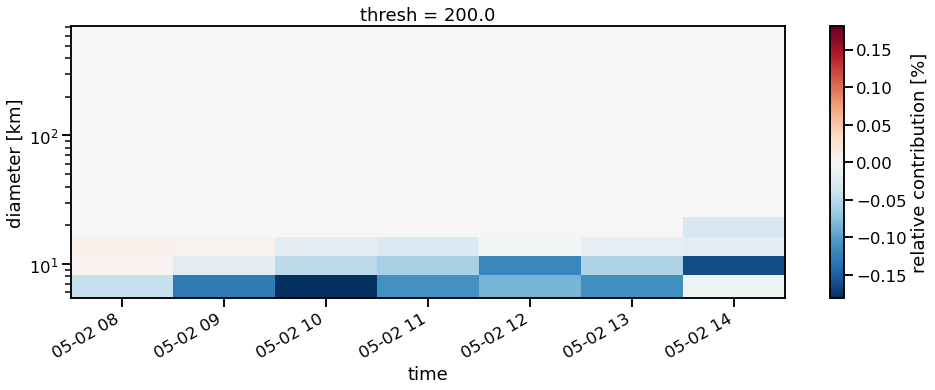

In [220]:
sd = 100. * sizediff_new.mean(['lmap','dom']).squeeze() / npix_all
sd.attrs = {'units': '%', 'long_name': 'relative contribution'}

sd.plot( x = 'time', y = 'diameter', figsize = (16,5) )
plt.yscale( 'log' )

In [221]:
sd.mean(['time', ]).sum('bin') 

<xarray.DataArray 'cluster' ()>
array(-0.17471737)
Coordinates:
    thresh   float64 200.0
Attributes:
    units:      %
    long_name:  relative contribution

## And both and new together

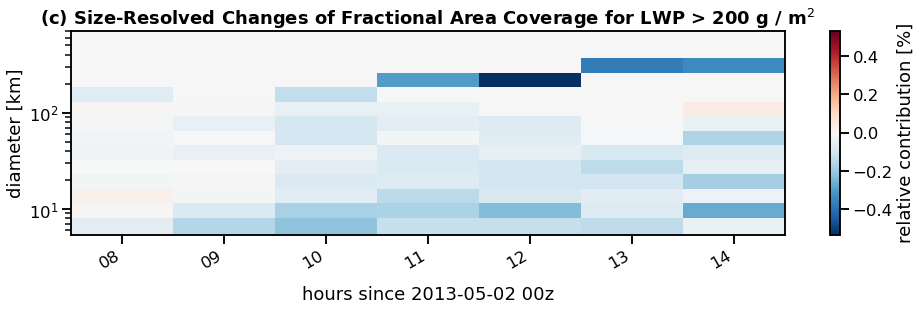

In [222]:
(sd + sd_both).plot( x = 'time', y = 'diameter', figsize = (16,4.5) )
plt.subplots_adjust( bottom = 0.25 )

plt.yscale( 'log' )
plt.title('(c) Size-Resolved Changes of Fractional Area Coverage for LWP > %d g / m${}^2$' % thresh,
         fontweight = 'bold')

plt.gca().xaxis.set_major_formatter(myFmt)
plt.xlabel('hours since 2013-05-02 00z', labelpad = 15 )
    
plt.savefig('../pics/frac-cellsize-change_LWP%d.png' % thresh, dpi = 300.)


## Size Distribution of All Cells

In [223]:
size_distrib_all = xr.apply_ufunc( binwise_average, s, s, sbins,
                input_core_dims = [ ['label'],['label'],['sbin'], ], 
                output_core_dims=[['bin']],
                vectorize = True, kwargs = dict( operator = np.sum) )

size_distrib_all = size_distrib_all.fillna( 0. )

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater_equal
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


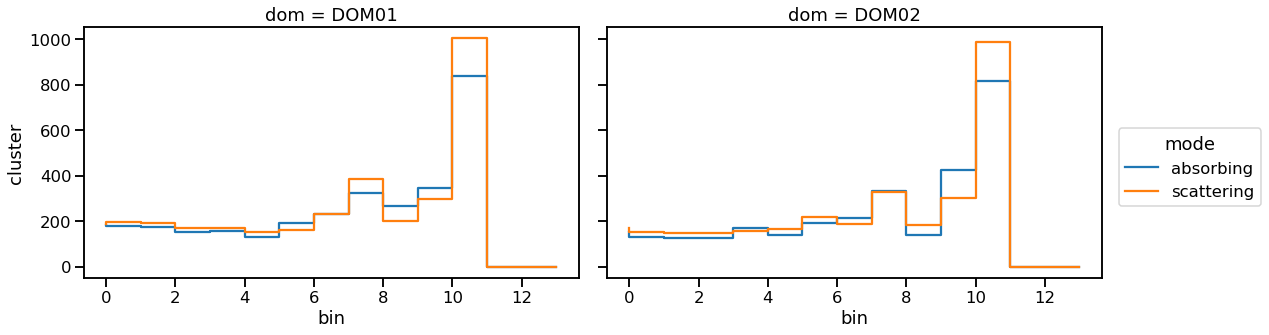

In [224]:
size_distrib_all.mean(['time', 'lmap']).plot(hue = 'mode', col = 'dom', figsize = (16,5), drawstyle = 'steps')

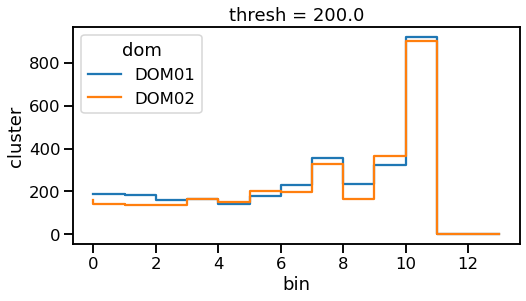

In [225]:
size_distrib_all.mean(['time', 'lmap', 'mode']).plot(hue = 'dom', figsize = (8,4), drawstyle = 'steps')

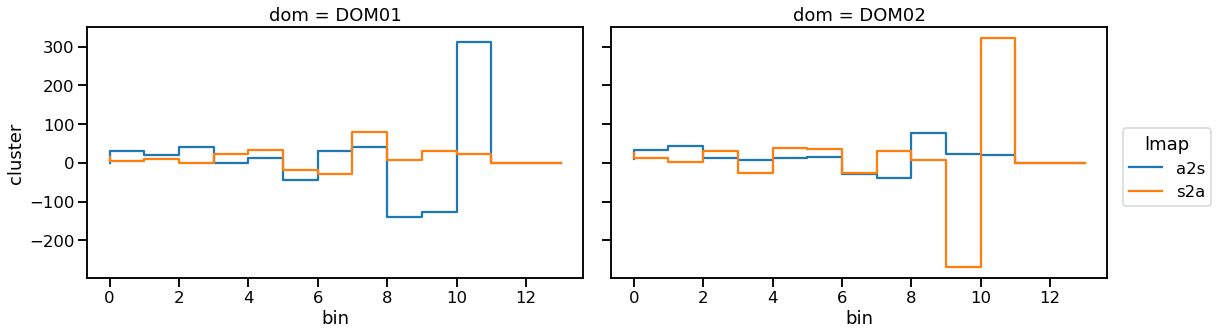

In [226]:
size_distrib_all.mean(['time',]).diff('mode').plot(hue = 'lmap', col = 'dom', figsize = (16,5), drawstyle = 'steps')

In [227]:
size_distrib_both = xr.apply_ufunc( binwise_average, sboth, sboth, sbins,
                input_core_dims = [ ['label'],['label'],['sbin'], ], 
                output_core_dims=[['bin']],
                vectorize = True, kwargs = dict( operator = np.sum) )

size_distrib_both = size_distrib_both.fillna( 0. )

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater_equal
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


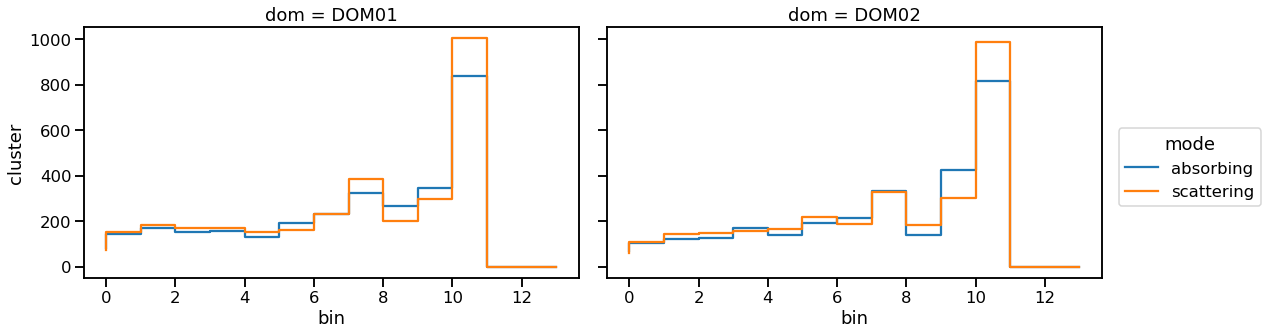

In [228]:
size_distrib_both.mean(['time', 'lmap']).plot(hue = 'mode', col = 'dom', figsize = (16,5), drawstyle = 'steps')

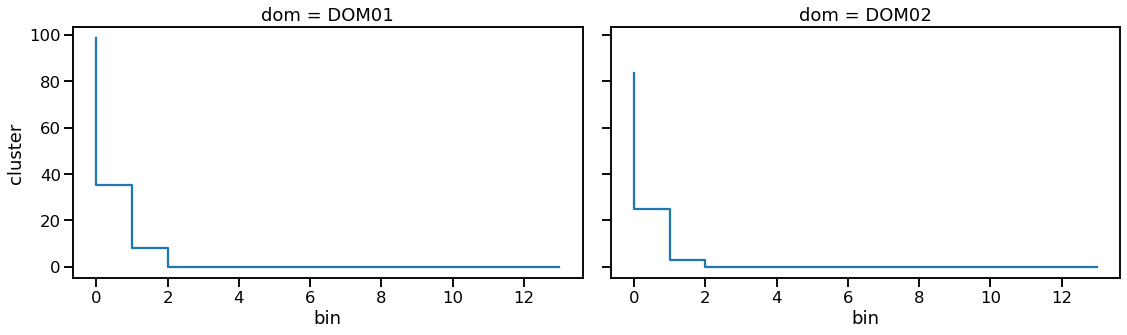

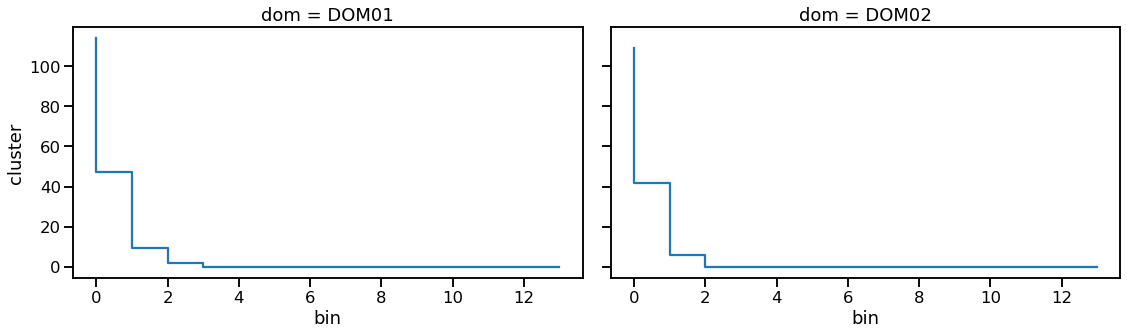

In [229]:
size_distrib_newabs.mean(['time', 'lmap']).plot(hue = 'mode', col = 'dom', figsize = (16,5), drawstyle = 'steps')
size_distrib_newsca.mean(['time', 'lmap']).plot(hue = 'mode', col = 'dom', figsize = (16,5), drawstyle = 'steps')


## Finally Some Numeric Values for the Differences

In [230]:
100 *( lwp > thresh )['clwvi'].mean( ['time', 'lat', 'lon', 'dom',])

<xarray.DataArray 'clwvi' (mode: 2)>
array([14.26582237, 15.12216955])
Coordinates:
  * mode     (mode) object 'absorbing' 'scattering'
Attributes:
    standard_name:  $Q_c$
    long_name:      liquid-water path
    units:          g m-3
    param:          215.1.0
    institution:    MPIMET

In [231]:
100 *size_distrib_all.mean(['time', 'lmap', 'dom',]).sum('bin') / npix_all

<xarray.DataArray 'cluster' (mode: 2)>
array([14.26582237, 15.12216955])
Coordinates:
    thresh   float64 200.0
  * mode     (mode) object 'absorbing' 'scattering'

In [232]:
100 * size_distrib_both.mean(['time', 'lmap', 'dom',]).sum('bin') / npix_all

<xarray.DataArray 'cluster' (mode: 2)>
array([13.67668998, 14.3583198 ])
Coordinates:
    thresh   float64 200.0
  * mode     (mode) object 'absorbing' 'scattering'

In [233]:
100 *size_distrib_newsca.mean(['time', 'lmap', 'dom',]).sum('bin') / npix_all

<xarray.DataArray 'cluster' ()>
array(0.76384975)
Coordinates:
    thresh   float64 200.0
    mode     <U10 'scattering'

In [234]:
100 * size_distrib_newabs.mean(['time', 'lmap', 'dom',]).sum('bin') / npix_all

<xarray.DataArray 'cluster' ()>
array(0.58913238)
Coordinates:
    thresh   float64 200.0
    mode     <U9 'absorbing'